(1, 2, 860, 513) 0.0 1.0


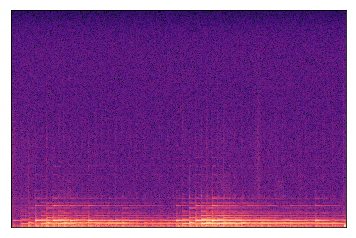

In [1]:
import tensorflow as tf
from librosa.display import specshow


def log10(x):
    return tf.log(x) / tf.log(10.0)


def rms(waveform):
    return tf.sqrt(tf.reduce_mean(waveform**2))


def load(audio_file_path, sample_rate=44100):
    x = tf.read_file(audio_file_path)
    x = tf.contrib.ffmpeg.decode_audio(x, 'wav', sample_rate, 2)
    x = tf.transpose(x)
    return x


def segment(waveform, duration=10.0, sample_rate=44100):
    n = int(sample_rate * duration)
    x = tf.contrib.signal.frame(waveform, n, n, pad_end=True)
    frames = tf.shape(x, out_type=tf.int64)[1]
    dataset = (
        tf.data.Dataset
        .range(frames)
        .map(lambda i: tf.gather(x, i, axis=1))
        .filter(lambda x: rms(x) > 0.01)
    )
    return dataset


def transform(waveform):
    z = tf.contrib.signal.stft(waveform, 1024, 512)
    magnitudes = tf.abs(z)
    power = magnitudes**2

    top_db = 120.0
    amin = 1e-9
    spectrogram = 10.0 * log10(tf.maximum(power, amin))
    spectrogram -= 10.0 * log10(1.0)
    spectrogram /= top_db

    return spectrogram


def minmax(spectrogram):
    x = spectrogram
    x -= tf.reduce_min(x)
    x /= tf.reduce_max(x)
    return x


def input_fn(batch_size=1):
    interleave = tf.contrib.data.parallel_interleave
    return (
        tf.data.Dataset
        .list_files('piano.wav')
        .shuffle(32)
        .repeat(10)
        .map(load)
        .apply(interleave(segment, batch_size))
        .map(transform)
        .map(minmax)
        .batch(batch_size)
    )


tf.reset_default_graph()
dataset = input_fn()
iterator = dataset.make_one_shot_iterator()
element = iterator.get_next()
with tf.Session():
    spectrograms = element.eval()
    print(spectrograms.shape, spectrograms.min(), spectrograms.max())
    assert spectrograms.min() >= 0.0
    assert spectrograms.max() <= 1.0
    specshow(spectrograms[0][0].T)